# Spaceship Titanic - Félix Laviéville

In [1]:
# %pip install kaggle pandas matplotlib seaborn scikit-learn==1.5.2 numpy xgboost

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Initialisation

On va récupérer toutes les données (train & test) dès maintenant pour un soucis d'efficacité

In [3]:
raw_df_train = pd.read_csv("train.csv")
raw_df_test = pd.read_csv("test.csv")
raw_df_train

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False


In [4]:
# on va rapidement altérer des données et/ou se baser sur des computed columns, donc on va les concaténer et les reséparer au moment des tests
all_data = pd.concat([raw_df_train, raw_df_test], axis=0)
# on reconstruit l'Index
all_data.reset_index(drop=False, inplace=True)
all_data

,index,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12965,4272,9266_02,Earth,True,G/1496/S,TRAPPIST-1e,34.0,False,0.0,0.0,0.0,0.0,0.0,Jeron Peter,NaN
12966,4273,9269_01,Earth,False,NaN,TRAPPIST-1e,42.0,False,0.0,847.0,17.0,10.0,144.0,Matty Scheron,NaN
12967,4274,9271_01,Mars,True,D/296/P,55 Cancri e,NaN,False,0.0,0.0,0.0,0.0,0.0,Jayrin Pore,NaN
12968,4275,9273_01,Europa,False,D/297/P,NaN,NaN,False,0.0,2680.0,0.0,0.0,523.0,Kitakan Conale,NaN


# Visualisation, analyse et nettoyage

À partir de all_data, nous allons visualiser différents graphiques pour tenter d'observer des corrélations entre les différentes variables, afin de combler les vides que nous avons dans notre jeu de données.

In [5]:
# Voici toutes les données que nous devons nettoyer (sauf Transported qui est naturellement bourré de vide à cause des tests)
all_data.isnull().sum().sort_values(ascending=False)

Transported     4277
CryoSleep        310
ShoppingMall     306
Cabin            299
VIP              296
Name             294
FoodCourt        289
HomePlanet       288
Spa              284
Destination      274
Age              270
VRDeck           268
RoomService      263
index              0
PassengerId        0
dtype: int64

### Pense-bête : interprétabilité des données


- **PassengerId** :<br>
A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.

- **HomePlanet** : <br>
The planet the passenger departed from, typically their planet of permanent residence.

- **CryoSleep** : <br>
Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.

- **Cabin** : <br>
The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.

- **Destination** : <br>
The planet the passenger will be debarking to.

- **Age** : <br>
The age of the passenger.

- **VIP** : <br>
Whether the passenger has paid for special VIP service during the voyage.

- **RoomService, FoodCourt, ShoppingMall, Spa, VRDeck** : <br>
Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.

- **Name** : <br>
The first and last names of the passenger.

- **Transported** : <br>
Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

In [6]:
# Split les cabines en données séparées
all_data[["Deck", "Cabin_num", "Side"]] = all_data["Cabin"].str.split("/", expand=True)
all_data[["Deck", "Cabin_num", "Side"]]

,Deck,Cabin_num,Side
0,B,0,P
1,F,0,S
2,A,0,S
3,A,0,S
4,F,1,S
...,...,...,...
12965,G,1496,S
12966,NaN,NaN,NaN
12967,D,296,P
12968,D,297,P


In [7]:
try:
    all_data = all_data.drop('Cabin', axis=1)
except KeyError:
    print("Tu l'as déjà supprimé, andouille")

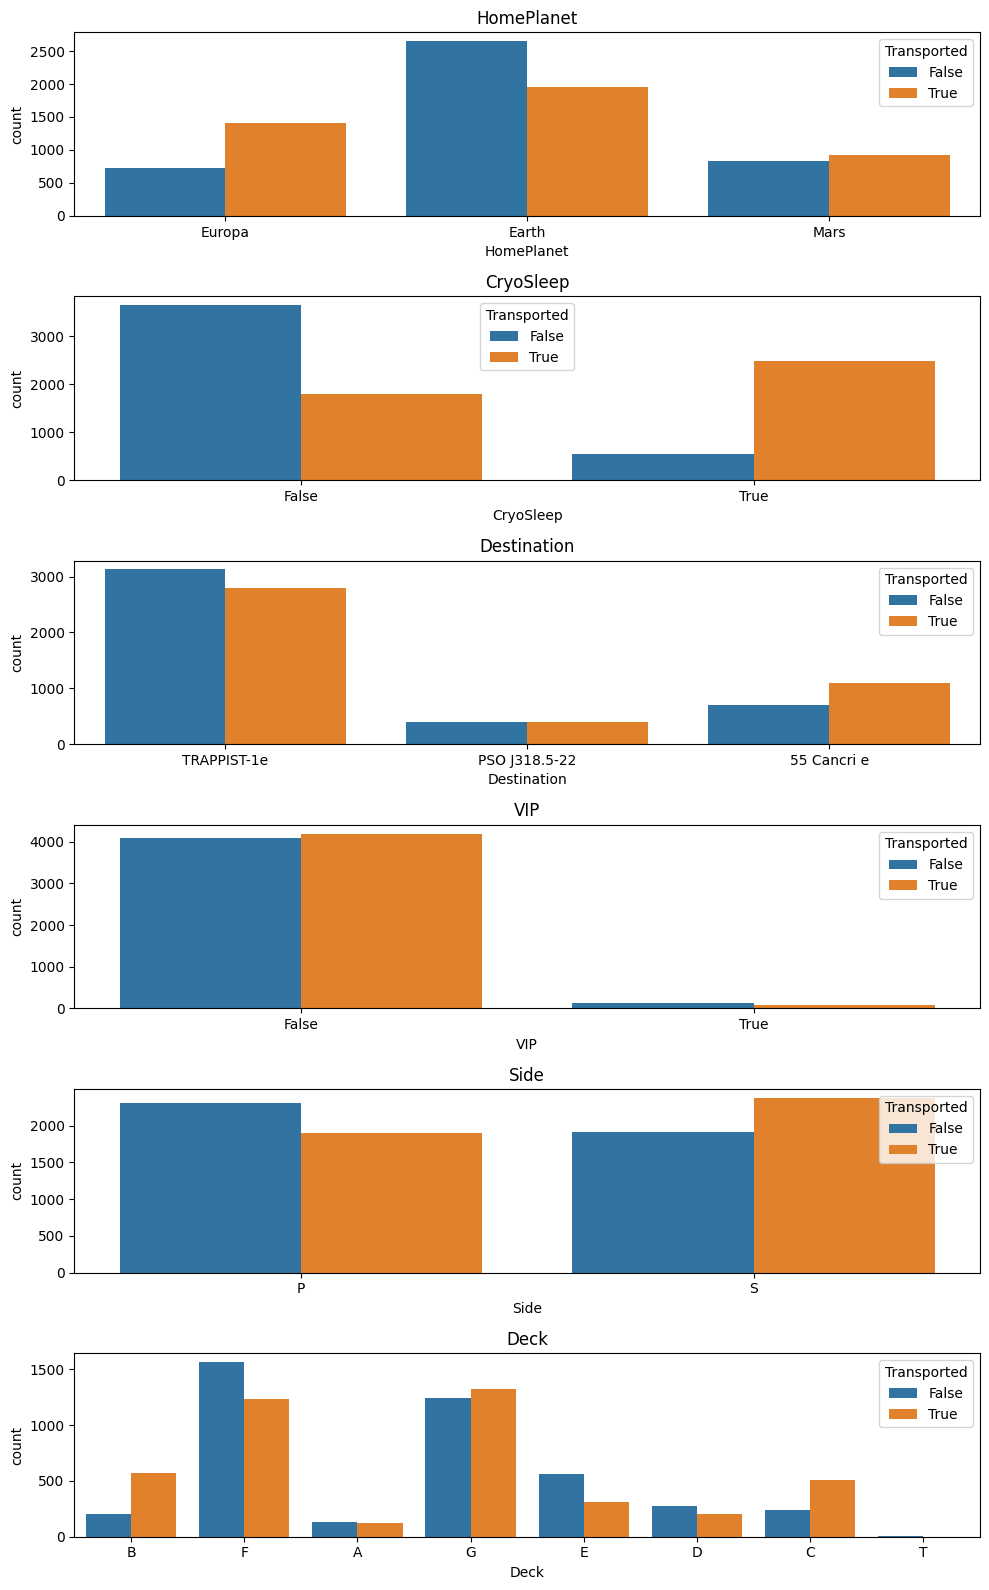

<Axes: xlabel='CryoSleep', ylabel='count'>

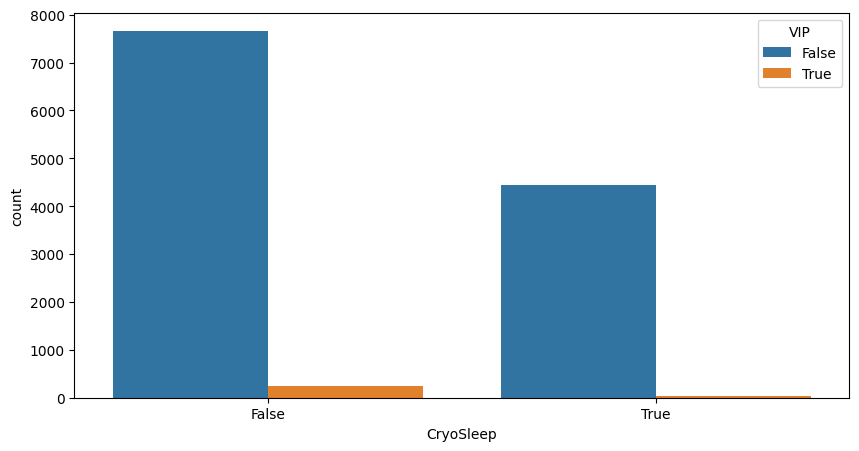

In [8]:
# allons au basique, on va afficher plusieurs graphiques pour commencer à observer les données
cat_feats=['HomePlanet', 'CryoSleep', 'Destination', 'VIP', "Side", "Deck"]


fig=plt.figure(figsize=(10,16))
for i, var_name in enumerate(cat_feats):
    ax=fig.add_subplot(6,1,i+1)
    sns.countplot(data=all_data, x=var_name, axes=ax, hue='Transported')
    ax.set_title(var_name)
fig.tight_layout()
plt.show()

# quelques spécifiques pour ne pas dépendre de transported pour nos lambdas

fig=plt.figure(figsize=(10,5))
sns.countplot(data=all_data, x='CryoSleep', hue='VIP')

In [9]:
# pour la phase de nettoyage évidente :

# vip n'est pas corrélé
all_data = all_data.drop(['VIP', 'Cabin_num'], axis=1)

# on n'utilisera pas de théorie par nom pour le moment, droppons
all_data = all_data.drop(['Name'], axis=1)

# Destination : il semblerait que la plupart allaient vers la première planète, on peut donc remplacer les NA par cette valeur
all_data['Destination'] = all_data['Destination'].fillna('TRAPPIST-1e')

# Homeplanet : Ils viennent globalement de la terre
all_data['HomePlanet'] = all_data['HomePlanet'].fillna('Earth')



<Axes: xlabel='HasExpense', ylabel='count'>

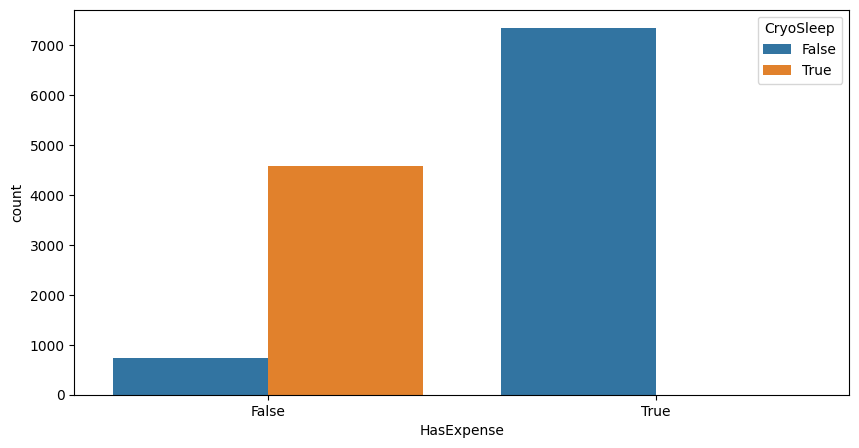

In [10]:
# CryoSleep : vérifions, sur les dépense 0, combien sont en sleeping
all_data["TotalExpense"] = all_data[['RoomService', 'Spa', 'FoodCourt', 'ShoppingMall', 'VRDeck']].sum(axis=1)
all_data['HasExpense'] = all_data['TotalExpense'] > 0

fig=plt.figure(figsize=(10,5))
sns.countplot(data=all_data, x='HasExpense', hue='CryoSleep')

In [11]:
# La quantité de gens non-dormants ne dépensant rien est négligeable, on peut donc dire HasExpense != CryoSleep
fillCryoSleep = lambda row: not row['HasExpense'] if pd.isna(row['CryoSleep']) else row['CryoSleep']
all_data['CryoSleep'] = all_data.apply(fillCryoSleep, axis=1)
all_data['CryoSleep'].isnull().sum()

np.int64(0)

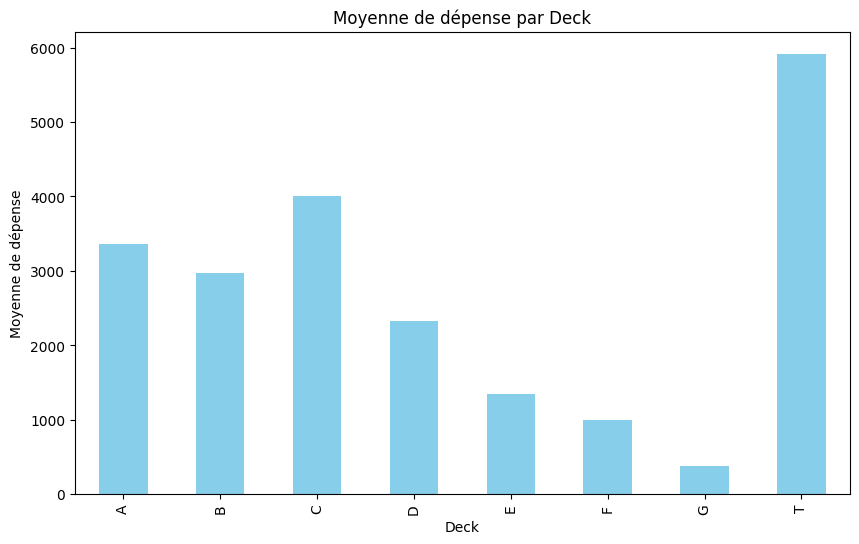

In [12]:
# Calculer la moyenne des dépenses par Deck, pour tenter de lier TotalExpense à la position dans le vaisseau
average_expense_by_deck = all_data.groupby('Deck')['TotalExpense'].mean()

# Tracer le graphique
plt.figure(figsize=(10, 6))
average_expense_by_deck.plot(kind='bar', color='skyblue')
plt.title('Moyenne de dépense par Deck')
plt.xlabel('Deck')
plt.ylabel('Moyenne de dépense')
plt.show()

In [13]:
# on observe que les dépenses les plus basses sont plutôt liées à un deck F ou G, c'est globalement linéaire avec A > B > ... > G (sauf T qu'on ne considère pas)
# on va suivre la tendance et renforcer A D et G sur ces critères
def fillDeck(row):
    if pd.isna(row['Deck']):
        t = row['TotalExpense']
        if t < 1000:
            return 'G'
        if t < 3000:
            return 'D'
        else:
            return 'A'
    return row['Deck']
all_data['Deck'] = all_data.apply(fillDeck, axis=1)
all_data['Deck'].isnull().sum()

np.int64(0)

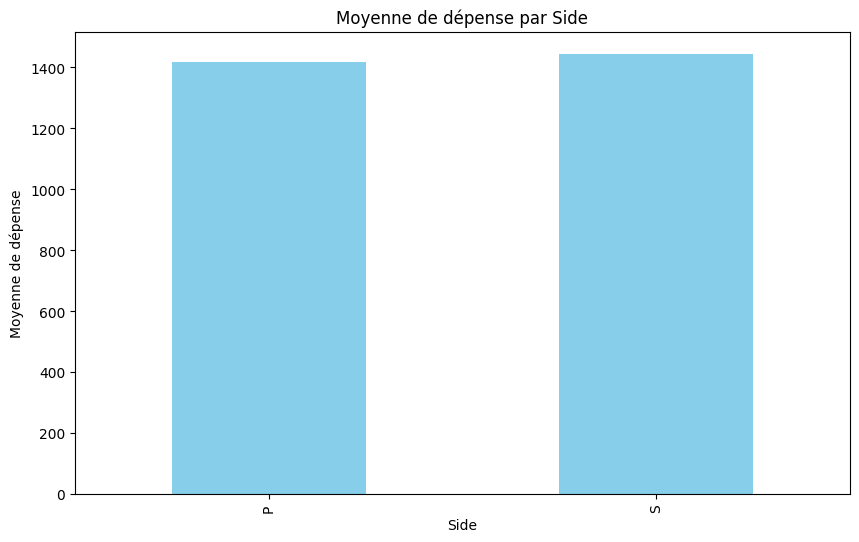

In [14]:
# Je suppute que si le deck du bateau compte, le côté aussi, vérifions

average_expense_by_side = all_data.groupby('Side')['TotalExpense'].mean()

# Tracer le graphique
plt.figure(figsize=(10, 6))
average_expense_by_side.plot(kind='bar', color='skyblue')
plt.title('Moyenne de dépense par Side')
plt.xlabel('Side')
plt.ylabel('Moyenne de dépense')
plt.show()

In [15]:
# bon ben pas du tout, on va juste drop Side pour le moment
all_data = all_data.drop('Side', axis=1)

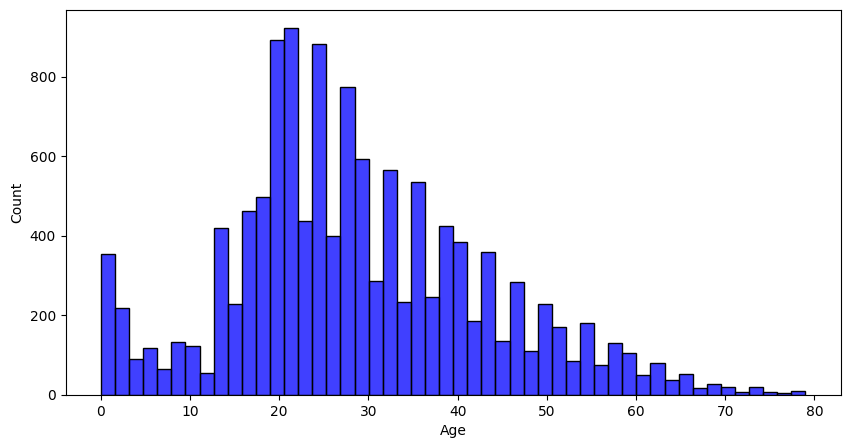

In [16]:
# Finalement, l'age, on va regarder la tendance des ages pour fill sans trop casser la distribution
plt.figure(figsize=(10,5))
sns.histplot(all_data['Age'], color='b', bins=50);

In [17]:
#On observe visuellement un pic vers 21-23 ans
# # je vais donc passer les NaN à 23 ans pour ne pas casser la tendance d'âge sans trop booster un âge au hasard.
all_data['Age'] = all_data['Age'].fillna(23)

In [18]:
# on peut nettoyer ce qui ne sert plus
all_data = all_data.drop([
    'TotalExpense',
    'HasExpense',
    'RoomService',
    'Spa',
    'FoodCourt',
    'ShoppingMall',
    'VRDeck',
    'Transported'
    ], axis=1)

In [19]:
all_data.isnull().sum().sort_values(ascending=False)

index          0
PassengerId    0
HomePlanet     0
CryoSleep      0
Destination    0
Age            0
Deck           0
dtype: int64

# Création du modèle XGBoost

In [20]:
# trouvons toutes les colonnes à parser :
all_data.dtypes

index            int64
PassengerId     object
HomePlanet      object
CryoSleep         bool
Destination     object
Age            float64
Deck            object
dtype: object

In [21]:
# parsons

cols = ['PassengerId', 'HomePlanet', 'CryoSleep', 'Destination', 'Deck']
# process columns, apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(all_data[c].values)) 
    all_data[c] = lbl.transform(list(all_data[c].values))

# shape        
print('Shape all_data: {}'.format(all_data.shape))

Shape all_data: (12970, 7)


In [22]:
df_train = all_data.iloc[:raw_df_train.shape[0]]
df_test = all_data.iloc[raw_df_train.shape[0]:]

df_train # pas de perte à noter, très bonne nouvelle par ailleurs *sueur*

,index,PassengerId,HomePlanet,CryoSleep,Destination,Age,Deck
0,0,0,1,0,2,39.0,1
1,1,1,0,0,2,24.0,5
2,2,2,1,0,2,58.0,0
3,3,3,1,0,2,33.0,0
4,4,4,0,0,2,16.0,5
...,...,...,...,...,...,...,...
8688,8688,12964,1,0,0,41.0,0
8689,8689,12966,0,1,1,18.0,6
8690,8690,12967,0,0,2,26.0,6
8691,8691,12968,1,0,0,32.0,4


In [23]:
df_test

,index,PassengerId,HomePlanet,CryoSleep,Destination,Age,Deck
8693,0,16,0,1,2,27.0,6
8694,1,22,0,0,2,19.0,5
8695,2,23,1,1,0,31.0,2
8696,3,30,1,0,2,38.0,2
8697,4,32,0,0,2,20.0,5
...,...,...,...,...,...,...,...
12965,4272,12950,0,1,2,34.0,6
12966,4273,12954,0,0,2,42.0,3
12967,4274,12956,2,1,0,23.0,3
12968,4275,12959,1,0,2,23.0,3


In [24]:
# Passons à la création d'un XGBClassifier

X = df_train
y = raw_df_train['Transported']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

model = XGBClassifier(n_estimators=5, max_depth=2, learning_rate=1, objective='binary:logistic')

model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=5, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [25]:
model.score(X_test, y_test)

0.7446808510638298

In [26]:
X_test = df_test.to_numpy()
y_pred = model.predict(X_test)

# Construisons un df_pred pour le submit
df_pred = pd.DataFrame()
df_pred["PassengerId"] = raw_df_test["PassengerId"] # on reprend le passengerId du raw

# on ajoute le transported calculé
df_pred["Transported"] = y_pred
df_pred["Transported"] = df_pred["Transported"].apply(bool) # 0, 1 -> False, True

df_pred.to_csv("prediction_xgboost.csv", index=False)

In [27]:
# !kaggle competitions submit -c spaceship-titanic -f prediction_xgboost.csv -m "XGBoost with basic cleaning"